In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklego.metrics import equal_opportunity_score
from sklego.metrics import p_percent_score
from sklearn.metrics import log_loss, accuracy_score
from sklearn.utils.extmath import squared_norm
from moopt.scalarization_interface import scalar_interface, single_interface, w_interface
from moopt import monise
import numpy as np
import optuna, sklearn, sklearn.datasets
from fair_models import coefficient_of_variation, MOOLogisticRegression, FindCLogisticRegression, FindCCLogisticRegression
from fair_models import calc_reweight
from fair_models import FairScalarization, EqualScalarization
from fair_models import SimpleVoting

import plotly.graph_objects as go

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.



In [2]:
from sklego.linear_model import DemographicParityClassifier
from sklego.linear_model import EqualOpportunityClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
def dominate(a, b):
    sense = np.array([1, 1, 1, 1])
    if all((sense*a)>=(sense*b)) and any((sense*a)>(sense*b)):
        return 1
    else:
        return 0

In [4]:
def all_metrics_parallel_coord(dataset, metric = 'accuracy',
                               acc_min = None, acc_max = None,
                               eo_min = None, eo_max = None,
                               pp_min=None, pp_max = None,
                               cv_min = None, cv_max = None):
    
    dominate_metr = np.array([any([dominate(other, row)
                                   for other in dataset.values])
                              for row in dataset.values])
    
    metrics = ['accuracy', 'equal_opportunity', 'p_percent', 'c_variation']
    
    met_aux = {"Modelo": [],
              "Acurácia": [],
              "Igualdade de Oportunidade": [],
              "P porcento": [],
              "Coeficiente de variação": [],
              'model_id': [],
              "metric_id": [],
              "metric": []}

    for m in range(len(metrics)):
        metric = metrics[m]
        
        met_aux["Modelo"].extend(['RegLogistica', 'EqualOp', 'ParDemo', 'Reweight', 'MinMax', 'ErroMO', 'ProbMO'])
        met_aux["Acurácia"].extend([dataset.loc[('LogReg',metric),metrics[0]],
                          dataset.loc[('RegEqual',metric),metrics[0]],
                          dataset.loc[('RegDemo',metric),metrics[0]],
                          dataset.loc[('RegRewe',metric),metrics[0]],
                          dataset.loc[('Minimax',metric),metrics[0]],
                          dataset.loc[('RegMoo',metric),metrics[0]],
                          dataset.loc[('RegEqMoo',metric),metrics[0]]])
        met_aux["Igualdade de Oportunidade"].extend([dataset.loc[('LogReg',metric),metrics[1]],
                          dataset.loc[('RegEqual',metric),metrics[1]],
                          dataset.loc[('RegDemo',metric),metrics[1]],
                          dataset.loc[('RegRewe',metric),metrics[1]],
                          dataset.loc[('Minimax',metric),metrics[1]],
                          dataset.loc[('RegMoo',metric),metrics[1]],
                          dataset.loc[('RegEqMoo',metric),metrics[1]]])
        met_aux["P porcento"].extend([dataset.loc[('LogReg',metric),metrics[2]],
                          dataset.loc[('RegEqual',metric),metrics[2]],
                          dataset.loc[('RegDemo',metric),metrics[2]],
                          dataset.loc[('RegRewe',metric),metrics[2]],
                          dataset.loc[('Minimax',metric),metrics[2]],
                          dataset.loc[('RegMoo',metric),metrics[2]],
                          dataset.loc[('RegEqMoo',metric),metrics[2]]])
        met_aux["Coeficiente de variação"].extend([dataset.loc[('LogReg',metric),metrics[3]],
                          dataset.loc[('RegEqual',metric),metrics[3]],
                          dataset.loc[('RegDemo',metric),metrics[3]],
                          dataset.loc[('RegRewe',metric),metrics[3]],
                          dataset.loc[('Minimax',metric),metrics[3]],
                          dataset.loc[('RegMoo',metric),metrics[3]],
                          dataset.loc[('RegEqMoo',metric),metrics[3]]])
        met_aux['model_id'].extend([0,1,2,3,4,5,6])
        met_aux['metric_id'].extend([m,m,m,m,m,m,m])
        met_aux['metric'].extend([metric,metric,metric,metric,metric,metric,metric])

    m_metrics = pd.DataFrame(data=met_aux, 
                                columns=['Modelo','Acurácia','Igualdade de Oportunidade','P porcento',
                                         'Coeficiente de variação','model_id', 'metric_id', 'metric'])
    
    acc_min = acc_min if acc_min is not None else m_metrics['Acurácia'].min()
    acc_max = acc_max if acc_max is not None else m_metrics['Acurácia'].max()
    eo_min = eo_min if eo_min is not None else m_metrics['Igualdade de Oportunidade'].min()
    eo_max = eo_max if eo_max is not None else m_metrics['Igualdade de Oportunidade'].max()
    pp_min = pp_min if pp_min is not None else m_metrics['P porcento'].min()
    pp_max = pp_max if pp_max is not None else m_metrics['P porcento'].max()
    cv_min = cv_min if cv_min is not None else m_metrics['Coeficiente de variação'].min()
    cv_max = cv_max if cv_max is not None else m_metrics['Coeficiente de variação'].max()

    fig = go.FigureWidget(data=
        go.Parcoords(
            line = dict(color = m_metrics['model_id'], 
                        colorscale = [(0.0, colors[0]),(0.14, colors[0]),
                            (0.14, colors[1]), (0.28, colors[1]),
                            (0.28, colors[2]),(0.42, colors[2]),
                            (0.42, colors[3]),(0.56, colors[3]),
                            (0.56, colors[4]),(0.7, colors[4]),
                            (0.7, colors[5]),(0.84, colors[5]),
                            (0.84, colors[6]),(1.0, colors[6])], 
                        showscale = True, cmin = 0, cmax = 6,
                       colorbar = {'tickvals': m_metrics['model_id'].tolist(),
                              'ticktext': m_metrics['Modelo'].tolist(),
                                  'title': 'Modelo'}),
            dimensions = list([
                dict(tickvals = [0,1,2,3],
                     ticktext = ['Acurácia','Iguald Oport','P porcento',
                                         'Coef de var'],
                     label = 'Métrica otimizada', values = m_metrics['metric_id']),
                #dict(tickvals = [0,1,2,3,4,5,6],
                #     ticktext = ['LogReg', 'RegEqual', 'RegDemo', 'RegRewe', 'Minimax','RegMoo', 'RegEqMoo'],
                #     label = 'Modelo', values = m_metrics['model_id']),
                dict(range = [acc_min, acc_max],
                    label = 'Acurácia', values = m_metrics['Acurácia']),
                dict(range = [eo_min, eo_max],
                    label = 'Igualdade de Oportunidade', values = m_metrics['Igualdade de Oportunidade']),
                dict(range = [pp_min, pp_max],
                    label = 'P porcento', values = m_metrics['P porcento']),
                dict(range = [cv_min, cv_max],
                    label = 'Coeficiente de variação', values = m_metrics['Coeficiente de variação']),
            ])
        ), layout = dict(height=400)#title = "Resultado para cada modelo - German")
    )
    
    def selection_handler(trace, points, selector):
        print(points, selection)

    fig.data[0].on_selection(selection_handler)
    
    
    fig.update_layout(
        plot_bgcolor = 'white',
        paper_bgcolor = 'white'
    )

    return fig

## COMPAS

In [5]:
data = pd.read_csv("Datasets - Limpos/compas_onerace.csv")
fair_feature = "not_white"
pred_feature = "Two_yr_Recidivism"

In [6]:
X = data.drop([pred_feature], axis=1)
y = data[pred_feature]


X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=1000)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=1000)

In [7]:
def calc_res(model__):
    return [accuracy_score(y_test, model__.predict(X_test)),
            equal_opportunity_score(sensitive_column=fair_feature)(model__, X_test, y_test),
            p_percent_score(sensitive_column=fair_feature)(model__, X_test),
            coefficient_of_variation(model__, X_test, y_test)]

In [8]:
colors = ['#003f5c','#7a5195','#bc5090','#ff764a','#ffa600']
methods = ['Acurácia', 'Igualdade de Oportunidade', 'P porcento', 'Coeficiente de variação', 'Ensemble']
metrics = ['Acurácia','Coeficiente de variação','Igualdade de Oportunidade','P porcento']

In [9]:
colormap = dict(zip(methods, colors))
methmap = dict(zip(methods, ['Acurácia', 'Igualdade de Oportunidade', 'P porcento', 'Coeficiente de variação', 'Ensemble']))

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Optionally use different styles for the graph
# Gallery: http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
# import matplotlib
# matplotlib.style.use('dark_background')  # interesting: 'bmh' / 'ggplot' / 'dark_background'


class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)+45

        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=16)

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid(False)
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label)
            ax.spines['polar'].set_visible(False)
            ax.set_ylim(0, 5.5)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)

In [11]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def build_radar(df_table, steps=4, shift=1, include_legend=True, plot_name = 'aux.jpg'):

    normz = pd.DataFrame(index=['min', 'max'], columns=metrics)
    for column in metrics:
        if column == 'Coeficiente de variação':
            normz[column] = [df_table[column].max(), df_table[column].min()]
        else:
            normz[column] = [df_table[column].min(), df_table[column].max()]
    
    fig = plt.figure(figsize=(4, 4))

    tit = ['Acc', 'CV', 'IO', 'P%']

    lab = [ [normz[metric]['min'].round(2), '', '', '', normz[metric]['max'].round(2)]
           for metric in metrics
          ]

    radar = Radar(fig, tit, lab)
    for idx in df_table.index:
        line = steps*(df_table.loc[idx]-normz.loc['min'])/(normz.loc['max']-normz.loc['min'])+1
        #print(line)
        #selected =  all((line>=selection.loc['min'])&(line<=selection.loc['max']))
        #alpha = 0.8 if selected else 0.05
        color = colormap[idx]# if selected else 'white'
        radar.plot(line, lw=2, color=color)

    if include_legend:
        legend_elements = [Line2D([0], [0], color=colormap[meth], label=methmap[meth])
                          for meth in methods]

        leg2 = radar.ax.legend(handles=legend_elements, bbox_to_anchor=(0.95, 0.95), loc='upper left', title='Selação por', 
                              fontsize = 10, title_fontsize=12)
        
        radar.ax.add_artist(leg2)
        
        fig.savefig(plot_name, bbox_extra_artists=(leg2,), bbox_inches='tight')
    else:
        fig.savefig(plot_name)

### Fair Moo

In [12]:
m_aux = {"Acurácia": [], "Coeficiente de variação": [], "Igualdade de Oportunidade": [], "P porcento": []}

In [13]:
moo_err = monise(weightedScalar=FairScalarization(X_train, y_train, fair_feature),
             singleScalar=FairScalarization(X_train, y_train, fair_feature),
              nodeTimeLimit=2, targetSize=150,
              targetGap=0, nodeGap=0.01, norm=False)

moo_err.optimize()

sols = []

for solution in moo_err.solutionsList:
    sols.append(solution.x)
    m_aux["Acurácia"].append(solution.x.score(X_test, y_test))
    m_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(solution.x,
                                                                                                            X_test, y_test))
    m_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(solution.x,X_test))
    m_aux["Coeficiente de variação"].append(coefficient_of_variation(solution.x, X_test, y_test))

2021-03-10 10:24:58,710 - moopt.monise - DEBUG: Finding 1th individual minima
2021-03-10 10:24:59,204 - moopt.monise - DEBUG: Finding 2th individual minima
2021-03-10 10:24:59,353 - moopt.monise - DEBUG: Finding 3th individual minima


Using license file /opt/gurobi/gurobi.lic
Academic license - for non-commercial use only


2021-03-10 10:25:00,076 - moopt.monise - DEBUG: 4th solution - importance: 1.0
2021-03-10 10:25:00,326 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-03-10 10:25:00,892 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-03-10 10:25:01,493 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-03-10 10:25:01,763 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-03-10 10:25:01,999 - moopt.monise - DEBUG: 9th solution - importance: 0.5800962763837305
2021-03-10 10:25:02,242 - moopt.monise - DEBUG: 10th solution - importance: 0.40115302848274026
2021-03-10 10:25:02,503 - moopt.monise - DEBUG: 11th solution - importance: 0.2984105995445307
2021-03-10 10:25:02,841 - moopt.monise - DEBUG: 12th solution - importance: 0.12345112441405776
2021-03-10 10:25:03,202 - moopt.monise - DEBUG: 13th solution - importance: 0.11949960021073355
2021-03-10 10:25:03,448 - moopt.monise - DEBUG: 14th solution - importance: 0.10121881820574172
2021-03-10 10:25:03,894 - moopt.

2021-03-10 10:26:17,935 - moopt.monise - DEBUG: 88th solution - importance: 2.8444868408887142e-05
2021-03-10 10:26:20,219 - moopt.monise - DEBUG: 89th solution - importance: 2.8444868408887142e-05
2021-03-10 10:26:22,509 - moopt.monise - DEBUG: 90th solution - importance: 3.190736434002709e-05
2021-03-10 10:26:24,825 - moopt.monise - DEBUG: 91th solution - importance: 3.190736434002709e-05
2021-03-10 10:26:27,241 - moopt.monise - DEBUG: 92th solution - importance: 3.190736434002709e-05
2021-03-10 10:26:29,648 - moopt.monise - DEBUG: 93th solution - importance: 3.190736434002709e-05
2021-03-10 10:26:31,936 - moopt.monise - DEBUG: 94th solution - importance: 3.190736434002709e-05
2021-03-10 10:26:34,217 - moopt.monise - DEBUG: 95th solution - importance: 2.9803317300211756e-05
2021-03-10 10:26:36,725 - moopt.monise - DEBUG: 96th solution - importance: 2.9803317300211756e-05
2021-03-10 10:26:39,152 - moopt.monise - DEBUG: 97th solution - importance: 3.131013890125381e-05
2021-03-10 10:26

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for not_white == 1, returning 0

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

divide by zero encountered in 

In [14]:
m_metrics = pd.DataFrame(data=m_aux, columns=['Acurácia',
                                     'Coeficiente de variação','Igualdade de Oportunidade','P porcento'])

In [15]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color='#e31a1c',
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0.0,1.0],
                label = 'Acurácia', values = m_metrics['Acurácia']),
            dict(range = [1.4,0.3],
                label = 'Coeficiente de variação', values = m_metrics['Coeficiente de variação']),
            dict(range = [0.0,1],
                label = 'Igualdade de Oportunidade', values = m_metrics['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = m_metrics['P porcento']),
        ])
    ), layout = dict(height=400, width=600)
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=12
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acurácia',
                              'range': [0.0,…

In [21]:
m_metrics.index

RangeIndex(start=0, stop=150, step=1)

In [22]:
metrics = ['Acurácia', 'Coeficiente de variação', 'Igualdade de Oportunidade', 'P porcento']
ens_resuls = pd.DataFrame(index=metrics+['Ensemble'], columns=metrics)
for metr in metrics:
    if metr=='Coeficiente de variação':
        min_idx = np.argmin(np.array(m_metrics['Coeficiente de variação']))
        #print(np.array(m_metrics['Coeficiente de variação'])[min_idx])
    else:
        min_idx = np.argmax(np.array(m_metrics[metr]))
        #print(np.array(m_metrics[metr])[min_idx])
        
    #min_model = moo_err.solutionsList[min_idx].x
    ens_resuls.loc[metr,:] = m_metrics.iloc[min_idx,:].values#calc_res(min_model)
    
selected_idx = m_metrics.index
for dimension in fig.data[0]['dimensions']:
    label = dimension['label']
        
    constr = dimension['constraintrange']
    print(constr)
    curr_pd = m_metrics.loc[selected_idx,:]
    if constr is not None:
        selected_idx = curr_pd[(curr_pd[label]>=constr[0])&(curr_pd[label]<=constr[1])].index

        
models_t = [("Model "+str(idx), moo_model.x) 
            for idx, moo_model in enumerate(moo_err.solutionsList)
            if idx in selected_idx]
ensemble_model = SimpleVoting(estimators=models_t, voting='soft')

ens_resuls.loc['Ensemble',:] = calc_res(ensemble_model)
ens_resuls

(0.6354881307552214, 0.7580875820583769)
None
None
None


,Acurácia,Coeficiente de variação,Igualdade de Oportunidade,P porcento
Acurácia,0.687,0.873613,0.623188,0.484504
Coeficiente de variação,0.44,0.449998,1,1
Igualdade de Oportunidade,0.56,1.25357,1,0
P porcento,0.44,0.449998,1,1
Ensemble,0.674,0.8,0.682757,0.908962


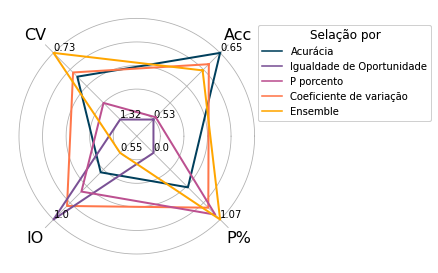

In [17]:
build_radar(ens_resuls, include_legend=True, plot_name = 'Plots/Result_COMPAS_all.jpg')

In [23]:
m_aux2 = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

In [24]:
moo = monise(weightedScalar=EqualScalarization(X_train, y_train, 'Sex'),
             singleScalar=EqualScalarization(X_train, y_train, 'Sex'),
              nodeTimeLimit=2, targetSize=150,
              targetGap=0, nodeGap=0.01, norm=False)

moo.optimize()

sols = []

for solution in moo.solutionsList:
    sols.append(solution.x)
    m_aux2["Acurácia"].append(solution.x.score(X_test, y_test))
    m_aux2["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=german_fair_feature)(solution.x,
                                                                                                            X_test, y_test))
    m_aux2["P porcento"].append(p_percent_score(sensitive_column=german_fair_feature)(solution.x,X_test))
    m_aux2["Coeficiente de variação"].append(coefficient_of_variation(solution.x, X_test, y_test))

2020-11-25 15:16:39,445 - moopt.monise - DEBUG: Finding 1th individual minima
2020-11-25 15:16:39,562 - moopt.monise - DEBUG: Finding 2th individual minima
2020-11-25 15:16:39,592 - moopt.monise - DEBUG: Finding 3th individual minima
2020-11-25 15:16:39,625 - moopt.monise - DEBUG: Finding 4th individual minima
2020-11-25 15:16:39,801 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2020-11-25 15:16:39,984 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2020-11-25 15:16:40,167 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2020-11-25 15:16:40,325 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2020-11-25 15:16:40,470 - moopt.monise - DEBUG: 9th solution - importance: 1.0
2020-11-25 15:16:40,621 - moopt.monise - DEBUG: 10th solution - importance: 0.6579383157494726
2020-11-25 15:16:40,801 - moopt.monise - DEBUG: 11th solution - importance: 0.6032974522515894
2020-11-25 15:16:41,090 - moopt.monise - DEBUG: 12th solution - importance: 0.4963426719690198
2020-11-

In [25]:
m_metrics2 = pd.DataFrame(data=m_aux2, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [21]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = new_results2['dominated'], 
                        colorscale = ['#0043E0', '#7F5EEF']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acurácia', values = m_metrics2['Acurácia']),
            dict(range = [0,1],
                label = 'Igualdade de Oportunidade', values = m_metrics2['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = m_metrics2['P porcento']),
            dict(range = [1.5,0.5],
                label = 'Coeficiente de variação', values = m_metrics2['Coeficiente de variação']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

## Logistic regression

In [40]:
import numpy as np

C_values = np.logspace(-10, 10, 150)

metrics_adult_log_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

for C in C_values:
    model = LogisticRegression(C=C, max_iter=10**3, tol=10**-6)
    model.fit(X_train, y_train)
    metrics_adult_log_aux["Acurácia"].append(model.score(X_test, y_test))
    metrics_adult_log_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=german_fair_feature)(model,
                                                                                                            X_test, y_test))
    metrics_adult_log_aux["P porcento"].append(p_percent_score(sensitive_column=german_fair_feature)(model,X_test))
    metrics_adult_log_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for Sex == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for Sex == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for Sex == 1, returning 0

/home/marcos/Documents

In [41]:
metrics_adult_log = pd.DataFrame(data=metrics_adult_log_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

metrics_adult_log['cv_aux'] = 1/metrics_adult_log['Coeficiente de variação']

metrics_adult_log = metrics_adult_log.drop('Coeficiente de variação', axis=1)
dominate_metr = [any([dominate(other, row) for other in metrics_adult_log.values]) for row in metrics_adult_log.values]
metrics_adult_log['dominated'] = dominate_metr

In [42]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acurácia', values = metrics_adult_log['Acurácia']),
            dict(range = [0,1],
                label = 'Igualdade de Oportunidade', values = metrics_adult_log['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = metrics_adult_log['P porcento']),
            dict(range = [1.2,3],
                label = 'cv_aux', values = metrics_adult_log['cv_aux']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

## Adult

In [43]:
data = pd.read_csv("Datasets - Limpos/adult.csv")
fair_feature = "race"
pred_feature = "income"

In [44]:
X = data.drop([pred_feature], axis=1)
y = data[pred_feature]


X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=5000)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=5000)

### Fair Moo

In [45]:
metrics_adult_fair_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

In [46]:
moo = monise(weightedScalar=FairScalarization(X_train, y_train, fair_feature),
             singleScalar=FairScalarization(X_train, y_train, fair_feature),
              nodeTimeLimit=2, targetSize=150,
              targetGap=0, nodeGap=0.01, norm=False)

moo.optimize()

sols = []

for solution in moo.solutionsList:
    sols.append(solution.x)
    metrics_adult_fair_aux["Acurácia"].append(solution.x.score(X_test, y_test))
    metrics_adult_fair_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(solution.x,
                                                                                                            X_test, y_test))
    metrics_adult_fair_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(solution.x,X_test))
    metrics_adult_fair_aux["Coeficiente de variação"].append(coefficient_of_variation(solution.x, X_test, y_test))

2020-11-12 17:27:54,376 - moopt.monise - DEBUG: Finding 1th individual minima
2020-11-12 17:27:54,767 - moopt.monise - DEBUG: Finding 2th individual minima
2020-11-12 17:27:55,415 - moopt.monise - DEBUG: Finding 3th individual minima
2020-11-12 17:27:55,849 - moopt.monise - DEBUG: 4th solution - importance: 1.0
2020-11-12 17:27:56,222 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2020-11-12 17:27:56,598 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2020-11-12 17:27:56,999 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2020-11-12 17:27:57,439 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2020-11-12 17:27:57,780 - moopt.monise - DEBUG: 9th solution - importance: 0.2518029585418239
2020-11-12 17:27:58,210 - moopt.monise - DEBUG: 10th solution - importance: 0.24617348594768693
2020-11-12 17:27:58,659 - moopt.monise - DEBUG: 11th solution - importance: 0.06248614541647035
2020-11-12 17:27:59,078 - moopt.monise - DEBUG: 12th solution - importance: 0.0606192

2020-11-12 17:29:03,275 - moopt.monise - DEBUG: 87th solution - importance: 8.448684363626858e-05
2020-11-12 17:29:05,004 - moopt.monise - DEBUG: 88th solution - importance: 6.135704002134124e-05
2020-11-12 17:29:07,462 - moopt.monise - DEBUG: 89th solution - importance: 6.135704002134124e-05
2020-11-12 17:29:09,865 - moopt.monise - DEBUG: 90th solution - importance: 6.135704002134124e-05
2020-11-12 17:29:12,065 - moopt.monise - DEBUG: 91th solution - importance: 6.135704002134124e-05
2020-11-12 17:29:14,513 - moopt.monise - DEBUG: 92th solution - importance: 6.135704002134124e-05
2020-11-12 17:29:16,619 - moopt.monise - DEBUG: 93th solution - importance: 6.135704002134124e-05
2020-11-12 17:29:19,069 - moopt.monise - DEBUG: 94th solution - importance: 6.135704002134124e-05
2020-11-12 17:29:21,409 - moopt.monise - DEBUG: 95th solution - importance: 6.135704002134124e-05
2020-11-12 17:29:23,874 - moopt.monise - DEBUG: 96th solution - importance: 6.135704002134124e-05
2020-11-12 17:29:26,

In [47]:
metrics_adult_fair = pd.DataFrame(data=metrics_adult_fair_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

metrics_adult_fair['cv_aux'] = 1/metrics_adult_fair['Coeficiente de variação']

metrics_adult_fair = metrics_adult_fair.drop('Coeficiente de variação', axis=1)
dominate_metr = [any([dominate(other, row) for other in metrics_adult_fair.values]) for row in metrics_adult_fair.values]
metrics_adult_fair['dominated'] = dominate_metr

In [48]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = metrics_adult_fair['dominated'], 
                        colorscale = ['rgba(0.0,0.0,255,0.0)', 'rgba(0.0,0.0,255,0.5)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acurácia', values = metrics_adult_fair['Acurácia']),
            dict(range = [0,1],
                label = 'Igualdade de Oportunidade', values = metrics_adult_fair['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = metrics_adult_fair['P porcento']),
            dict(range = [1.2,1.5],
                label = 'cv_aux', values = metrics_adult_fair['cv_aux']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

### Equal Moo

In [49]:
metrics_adult_equal_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

In [50]:
moo = monise(weightedScalar=EqualScalarization(X_train, y_train, fair_feature),
             singleScalar=EqualScalarization(X_train, y_train, fair_feature),
              nodeTimeLimit=2, targetSize=150,
              targetGap=0, nodeGap=0.01, norm=False)

moo.optimize()

sols = []

for solution in moo.solutionsList:
    sols.append(solution.x)
    metrics_adult_equal_aux["Acurácia"].append(solution.x.score(X_test, y_test))
    metrics_adult_equal_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(solution.x,
                                                                                                            X_test, y_test))
    metrics_adult_equal_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(solution.x,X_test))
    metrics_adult_equal_aux["Coeficiente de variação"].append(coefficient_of_variation(solution.x, X_test, y_test))

2020-11-12 17:31:41,879 - moopt.monise - DEBUG: Finding 1th individual minima
2020-11-12 17:31:42,634 - moopt.monise - DEBUG: Finding 2th individual minima
2020-11-12 17:31:42,815 - moopt.monise - DEBUG: Finding 3th individual minima
2020-11-12 17:31:42,996 - moopt.monise - DEBUG: Finding 4th individual minima
2020-11-12 17:31:43,864 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2020-11-12 17:31:43,989 - moopt.monise - DEBUG: 6th solution - importance: 1.0000009437597428
2020-11-12 17:31:44,115 - moopt.monise - DEBUG: 7th solution - importance: 1.0000009437597428
2020-11-12 17:31:44,242 - moopt.monise - DEBUG: 8th solution - importance: 1.0000009437597428
2020-11-12 17:31:44,369 - moopt.monise - DEBUG: 9th solution - importance: 1.0000009437597428
2020-11-12 17:31:44,497 - moopt.monise - DEBUG: 10th solution - importance: 1.0000009437597428
2020-11-12 17:31:44,625 - moopt.monise - DEBUG: 11th solution - importance: 1.0000009437597428
2020-11-12 17:31:44,753 - moopt.monise - DE

2020-11-12 17:31:55,660 - moopt.monise - DEBUG: 89th solution - importance: 1.0000009437597428
2020-11-12 17:31:55,814 - moopt.monise - DEBUG: 90th solution - importance: 1.0000009437597428
2020-11-12 17:31:55,971 - moopt.monise - DEBUG: 91th solution - importance: 1.0000009437597428
2020-11-12 17:31:56,127 - moopt.monise - DEBUG: 92th solution - importance: 1.0000009437597428
2020-11-12 17:31:56,284 - moopt.monise - DEBUG: 93th solution - importance: 1.0000009437597428
2020-11-12 17:31:56,441 - moopt.monise - DEBUG: 94th solution - importance: 1.0000009437597428
2020-11-12 17:31:56,598 - moopt.monise - DEBUG: 95th solution - importance: 1.0000009437597428
2020-11-12 17:31:56,756 - moopt.monise - DEBUG: 96th solution - importance: 1.0000009437597428
2020-11-12 17:31:56,914 - moopt.monise - DEBUG: 97th solution - importance: 1.0000009437597428
2020-11-12 17:31:57,072 - moopt.monise - DEBUG: 98th solution - importance: 1.0000009437597428
2020-11-12 17:31:57,231 - moopt.monise - DEBUG: 99

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Docume

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Docume

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Docume

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Docume

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Docume

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/home/marcos/Docume

In [51]:
metrics_adult_equal = pd.DataFrame(data=metrics_adult_equal_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

metrics_adult_equal['cv_aux'] = 1/metrics_adult_equal['Coeficiente de variação']

metrics_adult_equal = metrics_adult_equal.drop('Coeficiente de variação', axis=1)
dominate_metr = [any([dominate(other, row) for other in metrics_adult_equal.values]) for row in metrics_adult_equal.values]
metrics_adult_equal['dominated'] = dominate_metr

In [52]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acurácia', values = metrics_adult_equal['Acurácia']),
            dict(range = [0,1],
                label = 'Igualdade de Oportunidade', values = metrics_adult_equal['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = metrics_adult_equal['P porcento']),
            dict(range = [1.2,3],
                label = 'cv_aux', values = metrics_adult_equal['cv_aux']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [53]:
import numpy as np

C_values = np.logspace(-10, 10, 150)

metrics_adult_log_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

for C in C_values:
    model = LogisticRegression(C=C, max_iter=10**3, tol=10**-6)
    model.fit(X_train, y_train)
    metrics_adult_log_aux["Acurácia"].append(model.score(X_test, y_test))
    metrics_adult_log_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    metrics_adult_log_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    metrics_adult_log_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))

In [54]:
metrics_adult_log = pd.DataFrame(data=metrics_adult_log_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

metrics_adult_log['cv_aux'] = 1/metrics_adult_log['Coeficiente de variação']

metrics_adult_log = metrics_adult_log.drop('Coeficiente de variação', axis=1)
dominate_metr = [any([dominate(other, row) for other in metrics_adult_log.values]) for row in metrics_adult_log.values]
metrics_adult_log['dominated'] = dominate_metr

In [55]:
metrics_adult_log

,Acurácia,Igualdade de Oportunidade,P porcento,cv_aux,dominated
0,0.7906,0.857863,0.371588,1.375592,False
1,0.7900,0.910765,0.414919,1.373797,True
2,0.7894,0.957835,0.422259,1.372221,True
3,0.7890,0.939486,0.464014,1.371286,True
4,0.7886,0.925305,0.450326,1.370304,True
...,...,...,...,...,...
145,0.7884,0.932736,0.520582,1.382372,True
146,0.7884,0.932736,0.520582,1.382372,True
147,0.7884,0.932736,0.520582,1.382372,True
148,0.7884,0.932736,0.520582,1.382372,True


In [56]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acurácia', values = metrics_adult_log['Acurácia']),
            dict(range = [0,1],
                label = 'Igualdade de Oportunidade', values = metrics_adult_log['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = metrics_adult_log['P porcento']),
            dict(range = [1.2,3],
                label = 'cv_aux', values = metrics_adult_log['cv_aux']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [ ]:
C_values = np.logspace(-10, 10, 150)
c_values = np.linspace(1e-5, 1, 10)

metrics_adult_eqo_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

for C in C_values:
    for c in c_values:
        try:
            model = EqualOpportunityClassifier(sensitive_cols=fair_feature, positive_target=True, covariance_threshold=c, 
                                               C=C, max_iter=10**3)
            model.fit(X_train, y_train)
            metrics_adult_eqo_aux["Acurácia"].append(model.score(X_test, y_test))
            metrics_adult_eqo_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                                    X_test, y_test))
            metrics_adult_eqo_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
            metrics_adult_eqo_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
        except:
            print("C: ",C," - c: ",c)

C:  1e-10  - c:  1e-05
C:  1e-10  - c:  0.11112
C:  1e-10  - c:  0.22223
C:  1e-10  - c:  0.33334
C:  1e-10  - c:  0.44445
C:  1e-10  - c:  0.5555599999999999
C:  1e-10  - c:  0.66667
C:  1e-10  - c:  0.7777799999999999
C:  1e-10  - c:  0.88889
C:  1e-10  - c:  1.0
C:  1.3621602035512733e-10  - c:  1e-05
C:  1.3621602035512733e-10  - c:  0.11112
C:  1.3621602035512733e-10  - c:  0.22223
C:  1.3621602035512733e-10  - c:  0.33334
C:  1.3621602035512733e-10  - c:  0.44445
C:  1.3621602035512733e-10  - c:  0.5555599999999999
C:  1.3621602035512733e-10  - c:  0.66667
C:  1.3621602035512733e-10  - c:  0.7777799999999999
C:  1.3621602035512733e-10  - c:  0.88889
C:  1.3621602035512733e-10  - c:  1.0
C:  1.855480420138846e-10  - c:  1e-05
C:  1.855480420138846e-10  - c:  0.11112
C:  1.855480420138846e-10  - c:  0.22223
C:  1.855480420138846e-10  - c:  0.33334
C:  1.855480420138846e-10  - c:  0.44445
C:  1.855480420138846e-10  - c:  0.5555599999999999
C:  1.855480420138846e-10  - c:  0.66667
C:

In [ ]:
metrics_adult_eqo = pd.DataFrame(data=metrics_adult_eqo_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

metrics_adult_eqo['cv_aux'] = 1/metrics_adult_eqo['Coeficiente de variação']

metrics_adult_eqo = metrics_adult_eqo.drop('Coeficiente de variação', axis=1)
dominate_metr = [any([dominate(other, row) for other in metrics_adult_eqo.values]) for row in metrics_adult_eqo.values]
metrics_adult_eqo['dominated'] = dominate_metr

In [ ]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acurácia', values = metrics_adult_eqo['Acurácia']),
            dict(range = [0,1],
                label = 'Igualdade de Oportunidade', values = metrics_adult_eqo['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = metrics_adult_eqo['P porcento']),
            dict(range = [1.2,3],
                label = 'cv_aux', values = metrics_adult_eqo['cv_aux']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

## COMPAS

In [15]:
data = pd.read_csv("Datasets - Limpos/compas_onerace.csv")
fair_feature = "not_white"
pred_feature = "Two_yr_Recidivism"

In [16]:
X = data.drop([pred_feature], axis=1)
y = data[pred_feature]


X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=1000)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=1000)